In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

In [43]:
BATCH_SIZE = 32
INSTANCE_TYPE = "g5_xlarge"
data_local = pd.read_csv(f'video_inference_local_{INSTANCE_TYPE}_batch_{BATCH_SIZE}.csv')
data_s3 = pd.read_csv(f'video_inference_s3_{INSTANCE_TYPE}_batch_{BATCH_SIZE}.csv')


In [44]:
data_local.head()

,time_from_start,number_of_rows_finished
0,0.000000,0
1,12.995170,26
2,14.397536,52
3,15.798550,78
4,17.239616,104


In [45]:
def process(data, resample='30s'):
    data = data.copy()
    data['time_from_start'] = pd.to_timedelta(data['time_from_start'], unit='s')
    data.set_index('time_from_start', inplace=True)
    data['tput'] = data['number_of_rows_finished'].diff() / data.index.total_seconds().diff()
    data['tput'] = data['tput'].fillna(0)
    avg_tput = np.mean(data['tput'])
    # tput_resampled = data['tput'].resample(resample).bfill()
    tput_resampled = data['tput'].resample(resample).mean().ffill()
    idx = [str(item) for item in tput_resampled.index.to_pytimedelta()]
    return idx, tput_resampled.values, avg_tput

In [46]:
idx_local, values_local, avg_local = process(data_local)
idx_s3, values_s3, avg_s3 = process(data_s3)


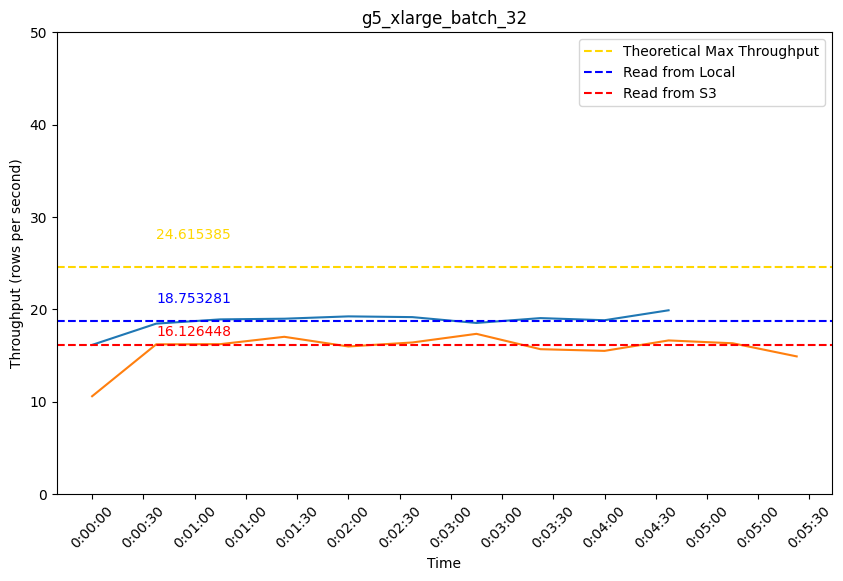

In [48]:
plt.figure(figsize=(10, 6))

plt.plot(idx_local, values_local)
plt.plot(idx_s3, values_s3)

plt.axhline(y=64/2.60, color='gold', linestyle='--', label='Theoretical Max Throughput')
plt.axhline(y=avg_local, color='blue', linestyle='--', label='Read from Local')
plt.axhline(y=avg_s3, color='red', linestyle='--', label='Read from S3') 

plt.text(1, 64/2.60 + 3, f'{np.round(64/2.60, 6)}', color='gold')
plt.text(1, avg_local + 2, f'{np.round(avg_local, 6)}', color='blue')  
plt.text(1, avg_s3 + 1, f'{np.round(avg_s3, 6)}', color='red')  

plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=20))

plt.xlabel('Time')
plt.ylabel('Throughput (rows per second)')
plt.ylim(0, 50) 
plt.title(f"{INSTANCE_TYPE}_batch_{BATCH_SIZE}")
plt.legend()
plt.show()

In [20]:
data = data_local

In [21]:
data['time_from_start'] = pd.to_timedelta(data['time_from_start'], unit='s')
data.set_index('time_from_start', inplace=True)
data.head()

,number_of_rows_finished
time_from_start,
0 days 00:00:00,0
0 days 00:00:24.065711737,64
0 days 00:00:26.937317610,128
0 days 00:00:34.137617826,192
0 days 00:00:38.946805239,256


In [23]:
data['tput'] = data['number_of_rows_finished'].diff() / data.index.total_seconds().diff()
data['tput'] = data['tput'].fillna(0)
data['tput']

time_from_start
0 days 00:00:00               0.000000
0 days 00:00:24.065711737     2.659385
0 days 00:00:26.937317610    22.287181
0 days 00:00:34.137617826     8.888518
0 days 00:00:38.946805239    13.307861
                               ...    
0 days 01:10:02.566852808    20.694870
0 days 01:10:08.862399578    10.165916
0 days 01:10:11.564971209    23.681148
0 days 01:10:14.180271149    24.471381
0 days 01:10:14.871382952    24.598046
Name: tput, Length: 840, dtype: float64

In [25]:
tput_resampled = data['tput'].resample('5s').mean().ffill()
tput_resampled

time_from_start
0 days 00:00:00     0.000000
0 days 00:00:05     0.000000
0 days 00:00:10     0.000000
0 days 00:00:15     0.000000
0 days 00:00:20     2.659385
                     ...    
0 days 01:09:50    15.294489
0 days 01:09:55    11.733092
0 days 01:10:00    20.694870
0 days 01:10:05    10.165916
0 days 01:10:10    24.250192
Freq: 5s, Name: tput, Length: 843, dtype: float64